# Chemistry Lab 3 - Lots of Profiles
**Developed for the OOI Data Lab Notebook**

By Sage Lichtenwalner

Revised August 21, 2020

This notebook is based on the prototype [notebook](https://github.com/ooi-data-lab/data-lab-workshops/blob/master/March2019/Activities/DL_March_Profiles_v2_Final.ipynb) developed for the *Ocean Profiles* Data Exploration, but has been simplified to process monthly averaged profiles for both the Coastal Pioneer and Global Argentine arrays.

This notebook also makes use of my new `ooilab` python library.

In [ ]:
# # Notebook setup
!pip install git+https://github.com/seagrinch/ooilab.git
import ooilab
import xarray as xr
!pip install netcdf4
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Make the Plots pretty
import seaborn as sns
sns.set()

# Supress open_mfdataset warnings
import warnings
warnings.filterwarnings('ignore')

  Cloning https://github.com/seagrinch/ooilab.git to /tmp/pip-req-build-i0r0xfe0
  Running command git clone -q https://github.com/seagrinch/ooilab.git /tmp/pip-req-build-i0r0xfe0
  Created wheel for ooilab: filename=ooilab-0.2-cp36-none-any.whl size=2506 sha256=d4783aca5b0de1d3f29362f46bc5ac8d72a549bdced0b924a6dfb3c468032fa7
  Stored in directory: /tmp/pip-ephem-wheel-cache-gsv0reqp/wheels/7f/c9/1d/60f91d31a29c5e03e8bc9dd7a58918a976a3f2ffe1ffcb3ea1
Successfully built ooilab


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Request Datasets
We first need to request all the datasets we will need to access.  This code only needs to be run once to get the urls.

The data for this activity comes from the following instruments.
* CP04OSPM-WFP01-03-CTDPFK000 (telemetered)
* GA02HYPM-WFP02-04-CTDPFL000 (recovered_wfp)
* And a bunch of fixed CTDs on the GA Surface Mooring

In [ ]:
ooilab.API_USERNAME = ''
ooilab.API_TOKEN = ''

start_time = '2015-04-01T00:00:00.000Z'
end_time = '2016-04-01T00:00:00.000Z'

In [ ]:
# GA Hybrid Profiler Mooring CTD
# ooilab.request_data('GA02HYPM-WFP02-04-CTDPFL000','recovered_wfp','ctdpf_ckl_wfp_instrument_recovered',start_time,end_time)

In [ ]:
# GA Surface Mooring Fixed CTDs
ctds = [
        {'depth':'12m','rd':'GA01SUMO-RID16-03-CTDBPF000','stream':'ctdbp_cdef_instrument_recovered'},
        {'depth':'20m','rd':'GA01SUMO-RII11-02-CTDMOQ011','stream':'ctdmo_ghqr_instrument_recovered'},
        {'depth':'40m','rd':'GA01SUMO-RII11-02-CTDBPP031','stream':'ctdbp_cdef_instrument_recovered'},
        {'depth':'40m2','rd':'GA01SUMO-RII11-02-CTDMOQ031','stream':'ctdmo_ghqr_instrument_recovered'},
        {'depth':'60m','rd':'GA01SUMO-RII11-02-CTDMOQ012','stream':'ctdmo_ghqr_instrument_recovered'},
        {'depth':'80m','rd':'GA01SUMO-RII11-02-CTDBPP032','stream':'ctdbp_cdef_instrument_recovered'},
        {'depth':'100m','rd':'GA01SUMO-RII11-02-CTDMOQ013','stream':'ctdmo_ghqr_instrument_recovered'},
        {'depth':'130m','rd':'GA01SUMO-RII11-02-CTDBPP033','stream':'ctdbp_cdef_instrument_recovered'},
        ]
# for ctd in ctds:
#   print(ctd['depth'])
#   url = ooilab.request_data(ctd['rd'],'recovered_inst',ctd['stream'],start_time,end_time)
#   print(url)

## 1. Load Data

Now that we have requested the data files, we can load and process them.  
First we will load all of the fixed CTDs to fill in the surface layer at Global Argentine.

In [ ]:
GA01SUMO_urls = [
  {'depth':'12m', 'url':'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20200821T195324409Z-GA01SUMO-RID16-03-CTDBPF000-recovered_inst-ctdbp_cdef_instrument_recovered/catalog.html'},
  {'depth':'20m', 'url':'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20200821T195325489Z-GA01SUMO-RII11-02-CTDMOQ011-recovered_inst-ctdmo_ghqr_instrument_recovered/catalog.html'},
  {'depth':'40m', 'url':'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20200821T195553501Z-GA01SUMO-RII11-02-CTDBPP031-recovered_inst-ctdbp_cdef_instrument_recovered/catalog.html'},
  {'depth':'40m2','url':'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20200821T195554311Z-GA01SUMO-RII11-02-CTDMOQ031-recovered_inst-ctdmo_ghqr_instrument_recovered/catalog.html'},
  {'depth':'60m', 'url':'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20200821T195327275Z-GA01SUMO-RII11-02-CTDMOQ012-recovered_inst-ctdmo_ghqr_instrument_recovered/catalog.html'},
  {'depth':'80m', 'url':'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20200821T195328084Z-GA01SUMO-RII11-02-CTDBPP032-recovered_inst-ctdbp_cdef_instrument_recovered/catalog.html'},
  {'depth':'100m','url':'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20200821T195329142Z-GA01SUMO-RII11-02-CTDMOQ013-recovered_inst-ctdmo_ghqr_instrument_recovered/catalog.html'},
  {'depth':'130m','url':'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20200821T195329702Z-GA01SUMO-RII11-02-CTDBPP033-recovered_inst-ctdbp_cdef_instrument_recovered/catalog.html'},
]

In [ ]:
# Load and merge all Fixed CTDS
ctd_all=False
for ctd in GA01SUMO_urls:
  print(ctd['depth'])
  ctd_files = ooilab.get_filelist(ctd['url'])
  ctd_data = xr.open_mfdataset(ctd_files).swap_dims({'obs': 'time'})
  if ctd['url'][146:151]=='ctdbp':
    ctd_data['pressure'] = ctd_data['ctdbp_seawater_pressure']
    ctd_data['seawater_temperature'] = ctd_data['ctdbp_seawater_temperature']
  else:
    ctd_data['pressure'] = ctd_data['ctdmo_seawater_pressure']
    ctd_data['seawater_temperature'] = ctd_data['ctdmo_seawater_temperature']
  ctd_data = ctd_data[['pressure','seawater_temperature','practical_salinity','density']].drop(['obs'])
  if(isinstance(ctd_all,xr.Dataset)):
    ctd_all = xr.concat([ctd_all, ctd_data],dim='time')
  else:
    ctd_all = ctd_data


12m
20m
40m
40m2
60m
80m
100m
130m


In [ ]:
# A little cleaning
ind = ctd_all['practical_salinity'] > 34
ctd_all['practical_salinity'] = ctd_all['practical_salinity'].where(ind)
ctd_all['density'] = ctd_all['density'].where(ind)

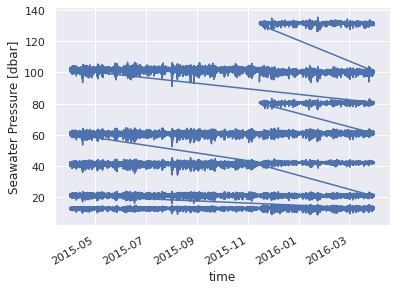

In [ ]:
ctd_all.pressure.plot();

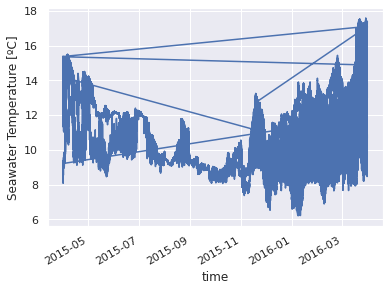

In [ ]:
ctd_all.seawater_temperature.plot();

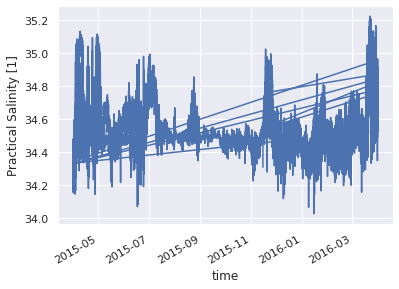

In [ ]:
ctd_all.practical_salinity.plot();

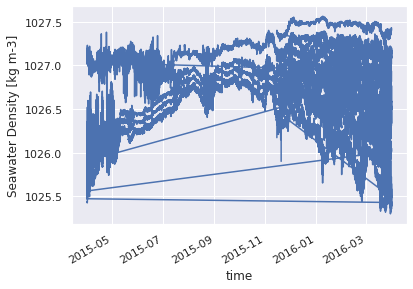

In [ ]:
ctd_all.density.plot();

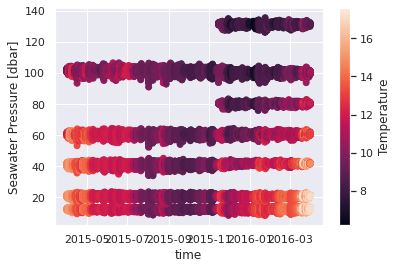

In [ ]:
sc = ctd_all.plot.scatter(x='time',y='pressure',c=ctd_all['seawater_temperature']);
plt.colorbar(sc,label='Temperature');

Now we will load the GA Hybrid Profiler.

In [ ]:
url_ga = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20200821T182000419Z-GA02HYPM-WFP02-04-CTDPFL000-recovered_wfp-ctdpf_ckl_wfp_instrument_recovered/catalog.html'

In [ ]:
# Get list of data files
ga_files = ooilab.get_filelist(url_ga)

In [ ]:
%%time
# Load the data files using xarray
ga_data = xr.open_mfdataset(ga_files).swap_dims({'obs': 'time'})
print('Dataset has %s points' % "{:,}".format(ga_data.time.size))

Dataset has 4,269,436 points
CPU times: user 1.22 s, sys: 286 ms, total: 1.51 s
Wall time: 12.9 s


In [ ]:
# Clean up the variables
ga_data['pressure'] = ga_data['ctdpf_ckl_seawater_pressure']
ga_data['seawater_temperature'] = ga_data['ctdpf_ckl_seawater_temperature']
ga_data = ga_data[['pressure','seawater_temperature','practical_salinity','density']].drop(['lon','lat','obs'])
ga_data = ga_data.reset_coords('pressure')

In [ ]:
# A little cleaning
ind = ga_data['practical_salinity'] > 33
ga_data['practical_salinity'] = ga_data['practical_salinity'].where(ind)
ga_data['density'] = ga_data['density'].where(ind)

And now we can merge the to GA datasets

In [ ]:
ga_all = xr.concat([ctd_all, ga_data],dim='time')
ga_all = ga_all.sortby('time')

## Bin Average the Data into Monthly Profiles

We'll do Argentine first, because it's more complicated.

In [ ]:
# Day and Depth Binning Function
def bindata(vd,binvar,bins):
  labels = (bins[:-1] + bins[1:])/2
  a = vd.groupby_bins(binvar,bins,labels=labels).mean(dim=xr.ALL_DIMS, skipna=True)
  return a

In [ ]:
# Calculate monthly averaged binned profiles
bins = np.concatenate((np.arange(0, 250, 10), np.arange(250, 2630, 50))) # Output depth bins
ga_profiles = ga_all.load().resample(time='1MS').apply(bindata,binvar='pressure',bins=bins)

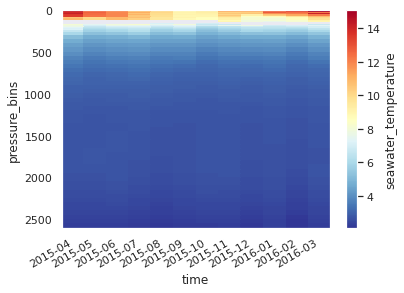

In [ ]:
# Quickplot
ga_profiles.seawater_temperature.plot(x='time',y='pressure_bins',cmap='RdYlBu_r',yincrease=False);
plt.savefig('ga_profiles_quick.png');

In [ ]:
# Convert dataset
ga_df = ga_profiles.to_dataframe().reset_index()

In [ ]:
# Export the data
ga_df.to_csv('ga_profiles.csv')

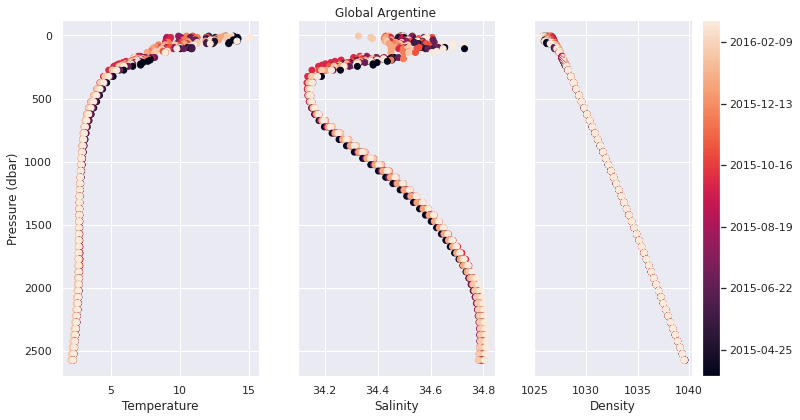

In [ ]:
# Plot the profiles
fig,(ax1,ax2,ax3) = plt.subplots(1,3, sharey=True, figsize=(12,6))
sc1 = ax1.scatter(ga_df.seawater_temperature, ga_df.pressure_bins, c=ga_df.time);
ax1.set_xlabel('Temperature')
ax2.scatter(ga_df.practical_salinity, ga_df.pressure_bins, c=ga_df.time);
ax2.set_xlabel('Salinity')
ax3.scatter(ga_df.density, ga_df.pressure_bins, c=ga_df.time);
ax3.set_xlabel('Density')

ax1.invert_yaxis();
ax1.set_ylabel('Pressure (dbar)')

cbar = fig.colorbar(sc1, ax=ax3, orientation='vertical')
# Fix the colorbar ticks
cbar.ax.set_yticklabels(pd.to_datetime(cbar.get_ticks()).strftime(date_format='%Y-%m-%d'));

fig.suptitle('Global Argentine')
fig.subplots_adjust(top=0.95);

fig.savefig('ga_profiles.png');

### Repeat for Pioneer
Now, we will load and average the Pioneer Offshore Profiler.  Note, this file was requested in another notebook and is from a different timeframe (2019).

In [ ]:
url_cp = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20200813T045539781Z-CP04OSPM-WFP01-03-CTDPFK000-telemetered-ctdpf_ckl_wfp_instrument/catalog.html'

In [ ]:
# Get list of data files
cp_files = ooilab.get_filelist(url_cp)

In [ ]:
%%time
# Load the data files using xarray
cp_data = xr.open_mfdataset(cp_files).swap_dims({'obs': 'time'})
print('Dataset has %s points' % "{:,}".format(cp_data.time.size))

Dataset has 3,889,811 points
CPU times: user 1.55 s, sys: 0 ns, total: 1.55 s
Wall time: 9.88 s


In [ ]:
# Clean up the variables
cp_data['pressure'] = cp_data['ctdpf_ckl_seawater_pressure']
cp_data['seawater_temperature'] = cp_data['ctdpf_ckl_seawater_temperature']
cp_data = cp_data[['pressure','seawater_temperature','practical_salinity','density']].drop(['lon','lat','obs'])

In [ ]:
# A little cleaning
ind = cp_data['practical_salinity'] > 32
cp_data['practical_salinity'] = cp_data['practical_salinity'].where(ind)
cp_data['density'] = cp_data['density'].where(ind)

In [ ]:
# Calculate monthly averaged binned profiles
bins = np.arange(0, 460, 10) # Output depth bins
cp_profiles = cp_data.resample(time='1MS').apply(bindata,binvar='pressure',bins=bins)

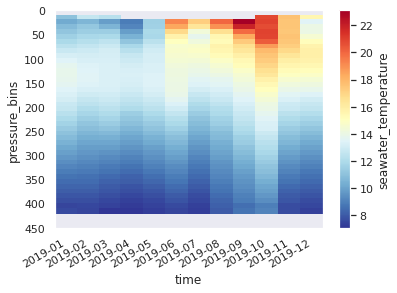

In [ ]:
# Quickplot
cp_profiles.seawater_temperature.plot(x='time',y='pressure_bins',cmap='RdYlBu_r',yincrease=False);
plt.savefig('cp_profiles_quick.png');

In [ ]:
# Convert dataset
cp_df = cp_profiles.to_dataframe().reset_index()

In [ ]:
# Export the data
cp_df.to_csv('cp_profiles.csv')

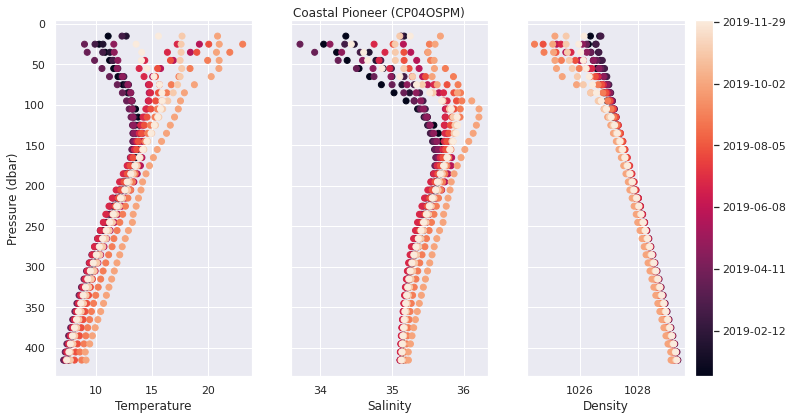

In [ ]:
# Plot the profiles
fig,(ax1,ax2,ax3) = plt.subplots(1,3, sharey=True, figsize=(12,6))
sc1 = ax1.scatter(cp_df.seawater_temperature, cp_df.pressure_bins, c=cp_df.time);
ax1.set_xlabel('Temperature')
ax2.scatter(cp_df.practical_salinity, cp_df.pressure_bins, c=cp_df.time);
ax2.set_xlabel('Salinity')
ax3.scatter(cp_df.density, cp_df.pressure_bins, c=cp_df.time);
ax3.set_xlabel('Density')

ax1.invert_yaxis();
ax1.set_ylabel('Pressure (dbar)')

cbar = fig.colorbar(sc1, ax=ax3, orientation='vertical')
# Fix the colorbar ticks
cbar.ax.set_yticklabels(pd.to_datetime(cbar.get_ticks()).strftime(date_format='%Y-%m-%d'));

fig.suptitle('Coastal Pioneer (CP04OSPM)')
fig.subplots_adjust(top=0.95);

fig.savefig('cp_profiles.png');